In [161]:
import pandas as pd
# sys.path.insert(0, 'D:\GitHub Repos\MLib in Python\MLib-in-python')
# import MLib
import warnings
warnings.filterwarnings("ignore")
import sklearn

In [162]:
DFOriginal = pd.read_csv('csv-wsn-ids-ds.csv')
OutPutLabel : str = 'Attack type'
InputLabels : list = DFOriginal.columns.tolist()
InputLabels.remove(OutPutLabel)
print('Input Labels Count: ', len(InputLabels))
InputLabels

Input Labels Count:  18


[' id',
 ' Time',
 ' Is_CH',
 ' who CH',
 ' Dist_To_CH',
 ' ADV_S',
 ' ADV_R',
 ' JOIN_S',
 ' JOIN_R',
 ' SCH_S',
 ' SCH_R',
 'Rank',
 ' DATA_S',
 ' DATA_R',
 ' Data_Sent_To_BS',
 ' dist_CH_To_BS',
 ' send_code ',
 'Expaned Energy']

In [163]:
DFOriginal[OutPutLabel].value_counts().index.tolist()

['Normal', 'Grayhole', 'Blackhole', 'TDMA', 'Flooding']

In [164]:
DFOriginal.dtypes

 id                   int64
 Time                 int64
 Is_CH                int64
 who CH               int64
 Dist_To_CH         float64
 ADV_S                int64
 ADV_R                int64
 JOIN_S               int64
 JOIN_R               int64
 SCH_S                int64
 SCH_R                int64
Rank                  int64
 DATA_S               int64
 DATA_R               int64
 Data_Sent_To_BS      int64
 dist_CH_To_BS      float64
 send_code            int64
Expaned Energy      float64
Attack type          object
dtype: object

In [165]:
DFOriginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374661 entries, 0 to 374660
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0    id               374661 non-null  int64  
 1    Time             374661 non-null  int64  
 2    Is_CH            374661 non-null  int64  
 3    who CH           374661 non-null  int64  
 4    Dist_To_CH       374661 non-null  float64
 5    ADV_S            374661 non-null  int64  
 6    ADV_R            374661 non-null  int64  
 7    JOIN_S           374661 non-null  int64  
 8    JOIN_R           374661 non-null  int64  
 9    SCH_S            374661 non-null  int64  
 10   SCH_R            374661 non-null  int64  
 11  Rank              374661 non-null  int64  
 12   DATA_S           374661 non-null  int64  
 13   DATA_R           374661 non-null  int64  
 14   Data_Sent_To_BS  374661 non-null  int64  
 15   dist_CH_To_BS    374661 non-null  float64
 16   send_code        37

In [166]:
# Display the number of missing values in each column
DFOriginal.isnull().sum()

 id                 0
 Time               0
 Is_CH              0
 who CH             0
 Dist_To_CH         0
 ADV_S              0
 ADV_R              0
 JOIN_S             0
 JOIN_R             0
 SCH_S              0
 SCH_R              0
Rank                0
 DATA_S             0
 DATA_R             0
 Data_Sent_To_BS    0
 dist_CH_To_BS      0
 send_code          0
Expaned Energy      0
Attack type         0
dtype: int64

In [167]:
DFOriginal.describe()

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy
count,3.746610e+05,374661.000000,374661.000000,3.746610e+05,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000,374661.000000
mean,2.749693e+05,1064.748712,0.115766,2.749804e+05,22.599380,0.267698,6.940562,0.779905,0.737493,0.288984,0.747452,9.687104,44.857925,73.890045,4.569448,22.562735,2.497957,0.305661
std,3.898986e+05,899.646164,0.319945,3.899112e+05,21.955794,2.061148,7.044319,0.414311,4.691498,2.754746,0.434475,14.681901,42.574464,230.246335,19.679155,50.261604,2.407337,0.669462
min,1.010000e+05,50.000000,0.000000,1.010000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.070930e+05,353.000000,0.000000,1.070960e+05,4.735440,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,13.000000,0.000000,0.000000,0.000000,1.000000,0.056150
50%,1.160710e+05,803.000000,0.000000,1.160720e+05,18.372610,0.000000,5.000000,1.000000,0.000000,0.000000,1.000000,3.000000,35.000000,0.000000,0.000000,0.000000,2.000000,0.097970
75%,2.150720e+05,1503.000000,0.000000,2.150730e+05,33.776000,0.000000,7.000000,1.000000,0.000000,0.000000,1.000000,13.000000,62.000000,0.000000,0.000000,0.000000,4.000000,0.217760
max,3.402096e+06,3600.000000,1.000000,3.402100e+06,214.274620,97.000000,117.000000,1.000000,124.000000,99.000000,1.000000,99.000000,241.000000,1496.000000,241.000000,201.934940,15.000000,45.093940


In [168]:
# Display the number of unique values in each column
DFOriginal.nunique()

 id                 11120
 Time                 196
 Is_CH                  2
 who CH              7088
 Dist_To_CH         13956
 ADV_S                 85
 ADV_R                 31
 JOIN_S                 2
 JOIN_R               101
 SCH_S                 95
 SCH_R                  2
Rank                  100
 DATA_S               192
 DATA_R              1345
 Data_Sent_To_BS      237
 dist_CH_To_BS        305
 send_code             16
Expaned Energy      69352
Attack type             5
dtype: int64

In [169]:
DFOriginal.drop_duplicates(inplace=True)

In [170]:
DFOriginal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365788 entries, 0 to 374660
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0    id               365788 non-null  int64  
 1    Time             365788 non-null  int64  
 2    Is_CH            365788 non-null  int64  
 3    who CH           365788 non-null  int64  
 4    Dist_To_CH       365788 non-null  float64
 5    ADV_S            365788 non-null  int64  
 6    ADV_R            365788 non-null  int64  
 7    JOIN_S           365788 non-null  int64  
 8    JOIN_R           365788 non-null  int64  
 9    SCH_S            365788 non-null  int64  
 10   SCH_R            365788 non-null  int64  
 11  Rank              365788 non-null  int64  
 12   DATA_S           365788 non-null  int64  
 13   DATA_R           365788 non-null  int64  
 14   Data_Sent_To_BS  365788 non-null  int64  
 15   dist_CH_To_BS    365788 non-null  float64
 16   send_code        365788 

array([[<Axes: title={'center': ' id'}>,
        <Axes: title={'center': ' Time'}>,
        <Axes: title={'center': ' Is_CH'}>,
        <Axes: title={'center': ' who CH'}>],
       [<Axes: title={'center': ' Dist_To_CH'}>,
        <Axes: title={'center': ' ADV_S'}>,
        <Axes: title={'center': ' ADV_R'}>,
        <Axes: title={'center': ' JOIN_S'}>],
       [<Axes: title={'center': ' JOIN_R'}>,
        <Axes: title={'center': ' SCH_S'}>,
        <Axes: title={'center': ' SCH_R'}>,
        <Axes: title={'center': 'Rank'}>],
       [<Axes: title={'center': ' DATA_S'}>,
        <Axes: title={'center': ' DATA_R'}>,
        <Axes: title={'center': ' Data_Sent_To_BS'}>,
        <Axes: title={'center': ' dist_CH_To_BS'}>],
       [<Axes: title={'center': ' send_code '}>,
        <Axes: title={'center': 'Expaned Energy'}>, <Axes: >, <Axes: >]],
      dtype=object)

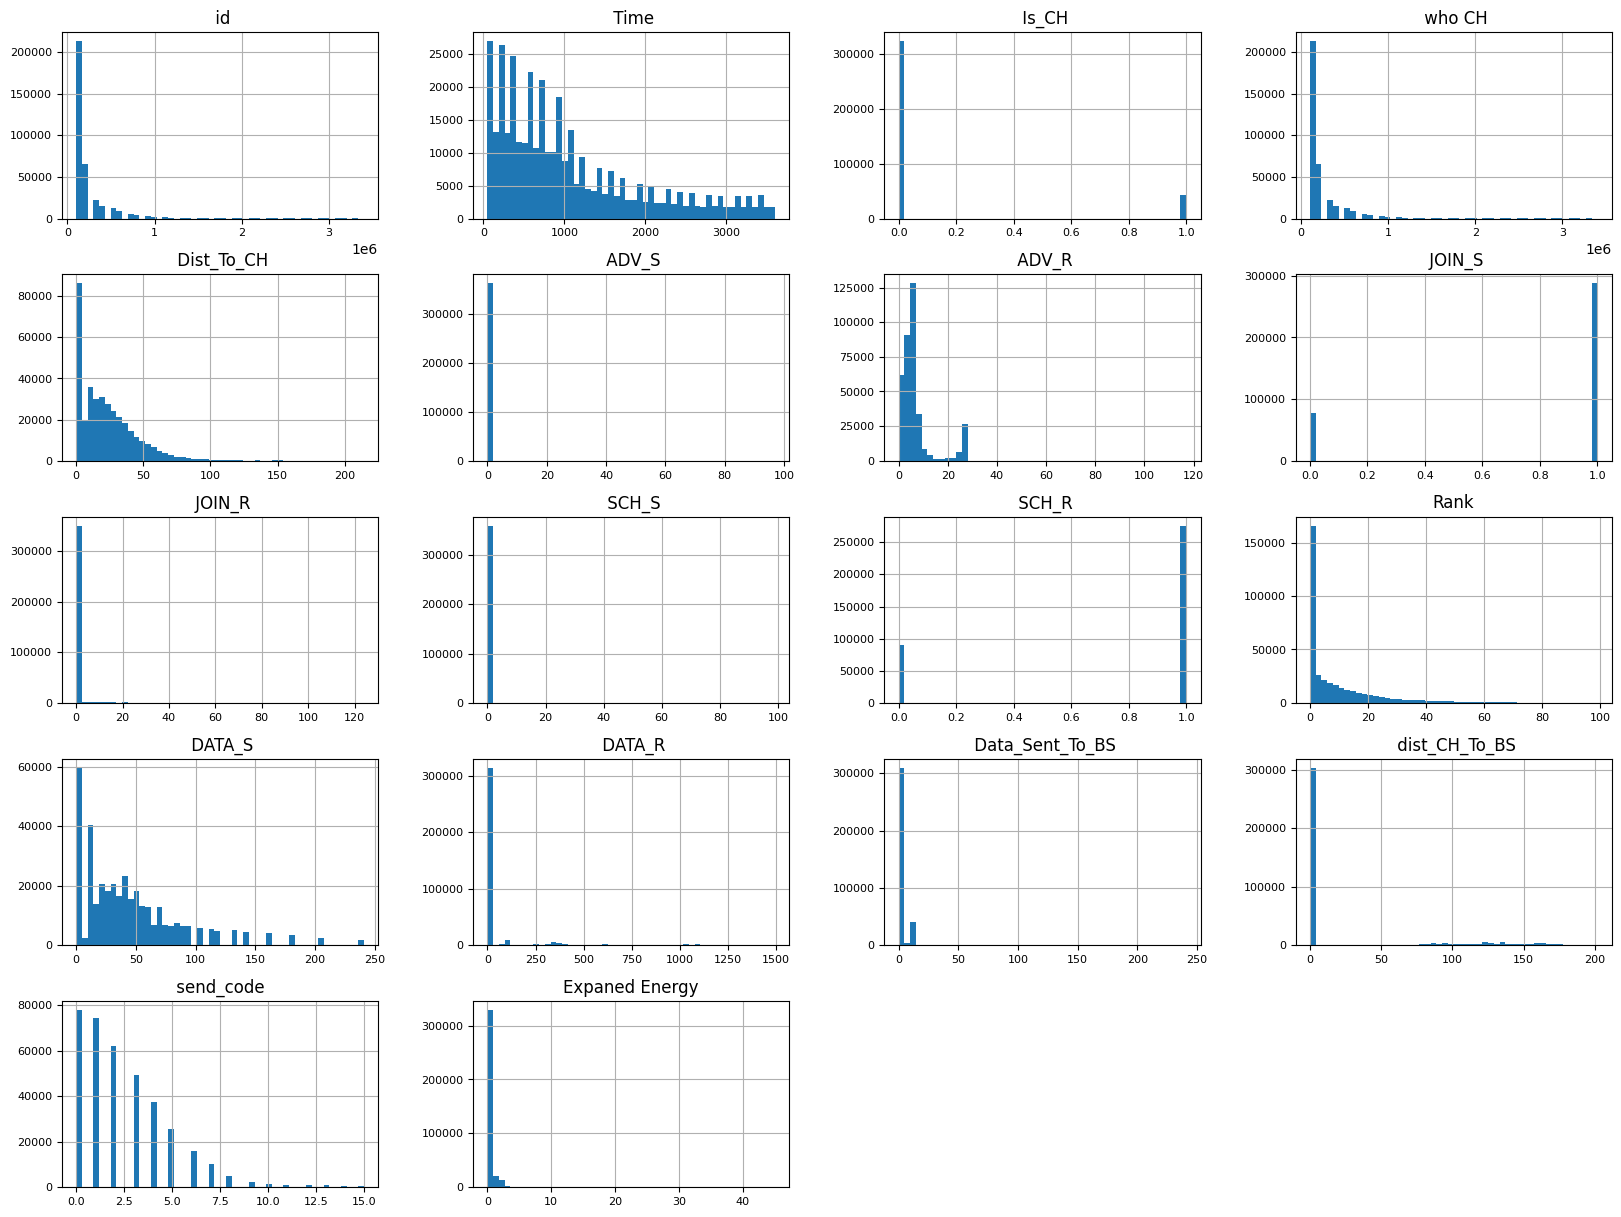

In [171]:
DFOriginal.hist(figsize=(20, 15), bins=50, xlabelsize=8, ylabelsize=8)

In [172]:
DFOriginal[OutPutLabel].value_counts()

Attack type
Normal       332040
Grayhole      13909
Blackhole     10049
TDMA           6633
Flooding       3157
Name: count, dtype: int64

In [173]:
# Display the first few rows of the dataset
DFOriginal.head()

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,Normal
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,Normal
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,Normal
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,Normal
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,Normal


In [174]:
DFOriginalInputs = DFOriginal[InputLabels]
DFOriginalOutput = DFOriginal[OutPutLabel]

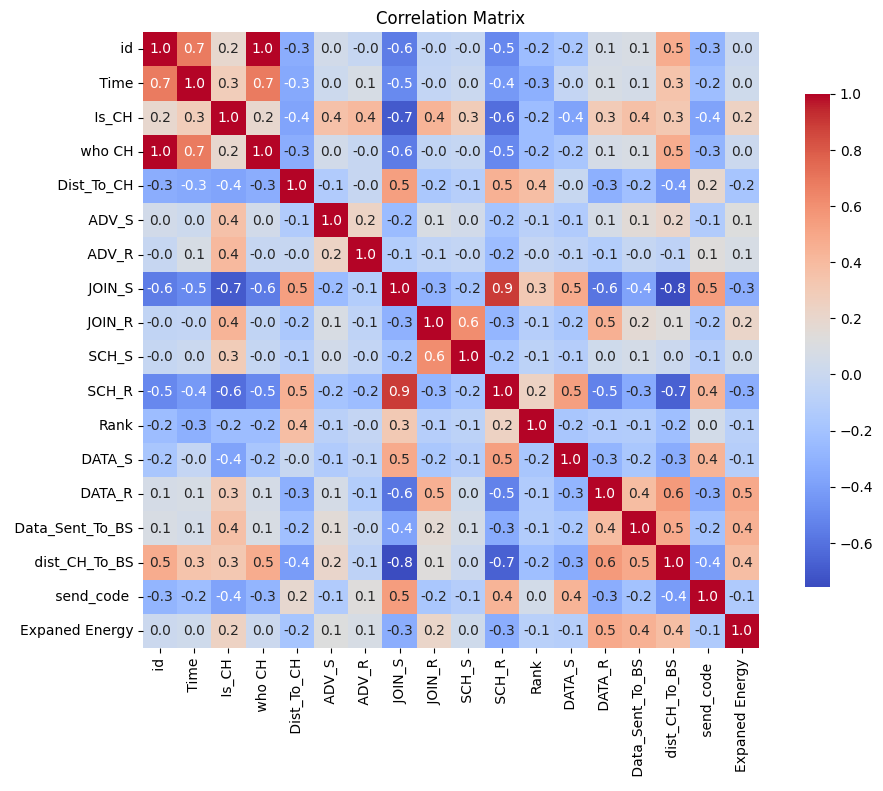

In [175]:
# print th correlation matrix with colored cells
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(DFOriginalInputs.corr(), annot=True, fmt=".1f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()


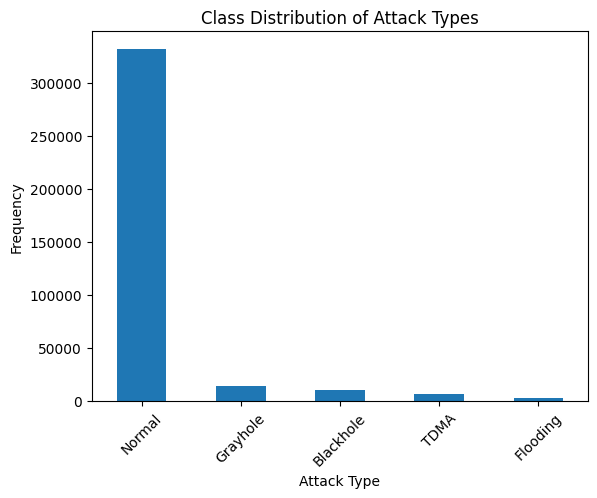

In [176]:
DFOriginalOutput.value_counts().plot(kind='bar')
plt.title('Class Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [177]:
from imblearn.over_sampling import SMOTE
def ResampleDFIO(DFinput : pd.DataFrame, DFoutput : pd.DataFrame) -> pd.DataFrame:
    smote = SMOTE()
    DFSampledinput, DFSampledoutput = smote.fit_resample(DFinput, DFoutput)
    # merge thsamplede  inputs and outputs back into a single DataFrame
    DFSampled = pd.concat([DFSampledinput, DFSampledoutput], axis=1)
    return DFSampled

In [178]:
def LabelEncoding(DF : pd.DataFrame) -> pd.DataFrame:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    encoded = le.fit_transform(DF)
    return pd.DataFrame(encoded, columns=DF.columns)

In [179]:
def OneHotEncoding(DF : pd.DataFrame) -> pd.DataFrame:
    from sklearn.preprocessing import OneHotEncoder
    categorical_columns = DF.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    encoded = ohe.fit_transform(DF[categorical_columns])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorical_columns))
    DFONE = pd.concat([DF.drop(columns=categorical_columns), encoded_df], axis=1)
    return DFONE


In [180]:
DFOriginalInputs.shape, DFOriginalOutput.shape

((365788, 18), (365788,))

In [181]:
DFOriginalOutput = pd.DataFrame(DFOriginalOutput)
DFLEOutput = LabelEncoding(DFOriginalOutput)
DFLEOutput.head()

,Attack type
0,3
1,3
2,3
3,3
4,3


<Axes: xlabel='Attack type'>

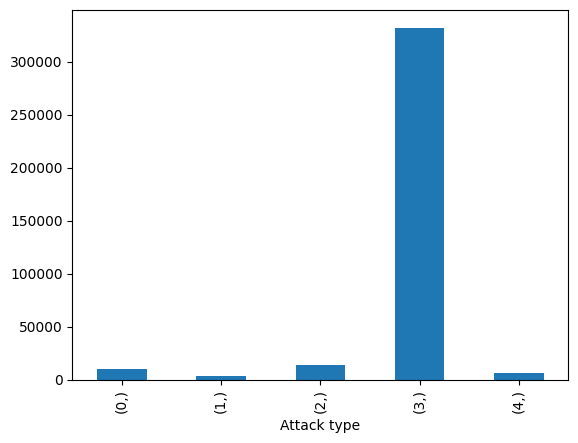

In [182]:
DFLEOutput.value_counts().sort_index().plot(kind='bar')

In [183]:
DFOHEOutput = OneHotEncoding(DFOriginalOutput)
DFOHEOutput.head()
DFInputOHEOutput = pd.concat([DFOriginal.drop(columns=OutPutLabel), DFOHEOutput], axis=1)

In [184]:
DFInputOHEOutput.head()

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,...,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type_Blackhole,Attack type_Flooding,Attack type_Grayhole,Attack type_Normal,Attack type_TDMA
0,101000.0,50.0,1.0,101000.0,0.00000,1.0,0.0,0.0,25.0,1.0,...,1200.0,48.0,130.08535,0.0,2.46940,0.0,0.0,0.0,1.0,0.0
1,101001.0,50.0,0.0,101044.0,75.32345,0.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.00000,4.0,0.06957,0.0,0.0,0.0,1.0,0.0
2,101002.0,50.0,0.0,101010.0,46.95453,0.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.00000,3.0,0.06898,0.0,0.0,0.0,1.0,0.0
3,101003.0,50.0,0.0,101044.0,64.85231,0.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.00000,4.0,0.06673,0.0,0.0,0.0,1.0,0.0
4,101004.0,50.0,0.0,101010.0,4.83341,0.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.00000,3.0,0.06534,0.0,0.0,0.0,1.0,0.0


In [185]:
CorrelationMatrixInputOHEOutput = DFInputOHEOutput.corr()

<Axes: >

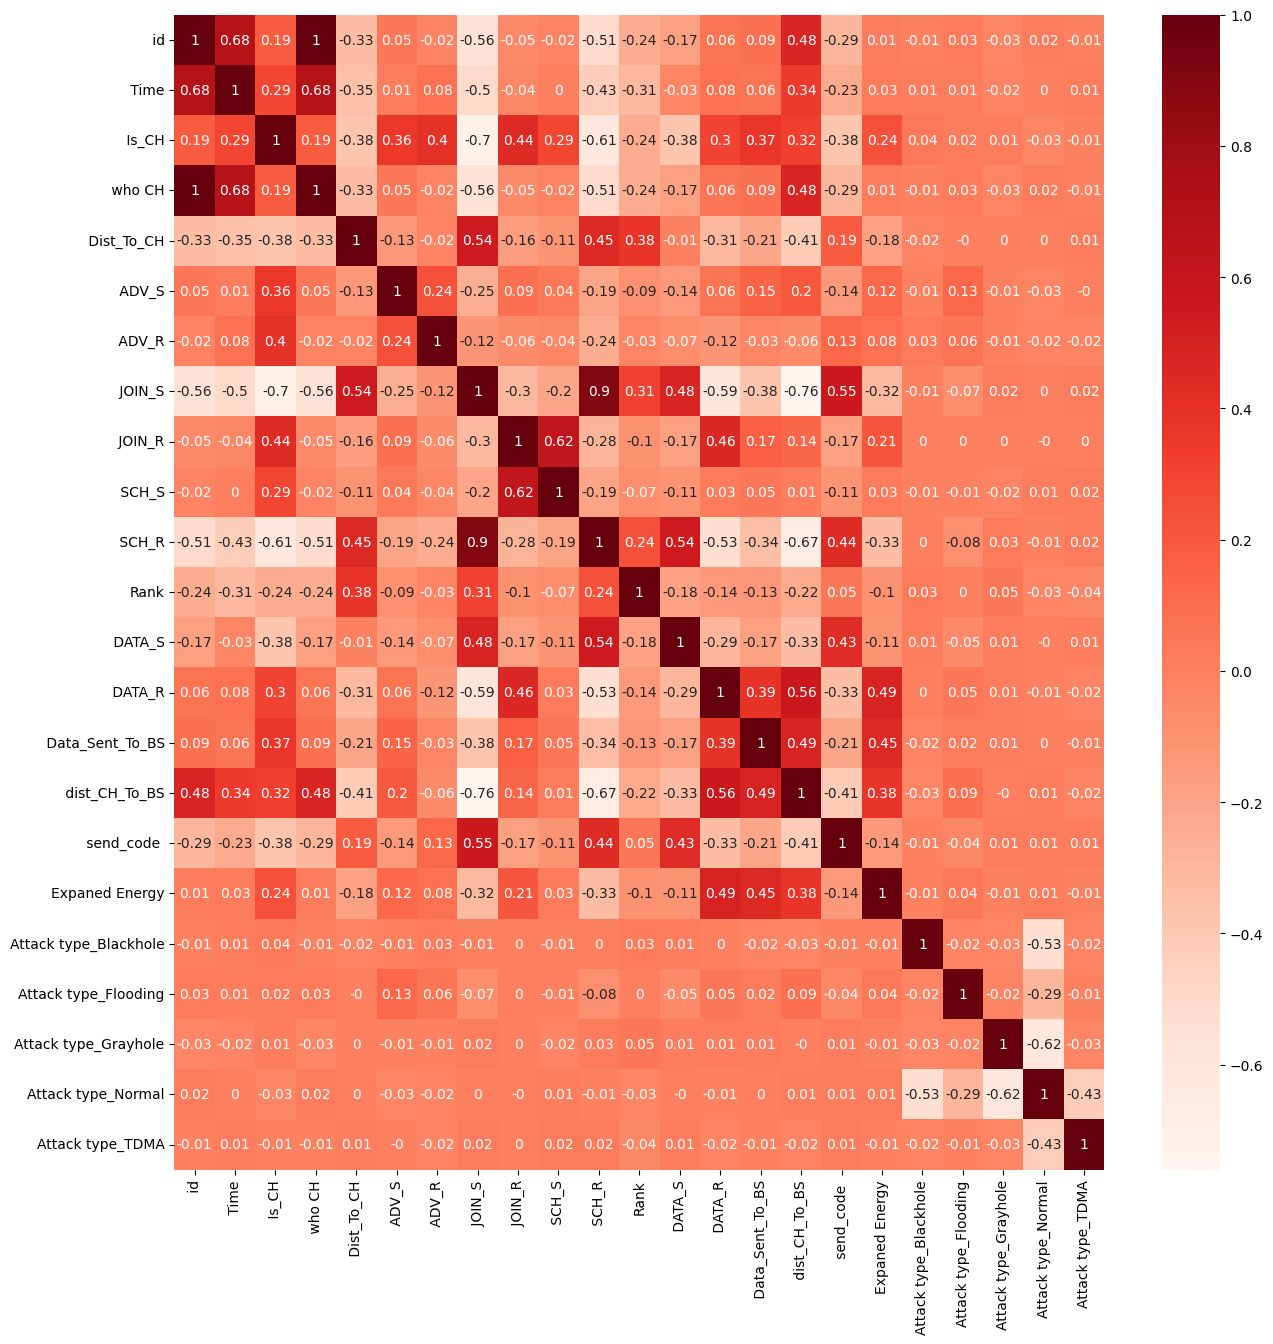

In [186]:
CorrelationMatrixInputOHEOutput = CorrelationMatrixInputOHEOutput.round(2)
plt.subplots(figsize=(15,15))
sns.heatmap(CorrelationMatrixInputOHEOutput, cmap='Reds', annot=True)

In [187]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
TrainInput, TestInput, TrainOutput, TestOutput = train_test_split(DFOriginalInputs, DFLEOutput, train_size=0.8, random_state=42, stratify=DFLEOutput)

In [188]:
# TODO: use other scaling methods, like standardscaler, robustscaler

mms = sklearn.preprocessing.MinMaxScaler()
DFTrainInputScaled = pd.DataFrame(mms.fit_transform(TrainInput), columns=TrainInput.columns)
DFTestInputScaled = pd.DataFrame(mms.transform(TestInput), columns=TestInput.columns)

In [189]:
DFTrainInputScaled

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy
0,0.005176,0.240282,0.0,0.005171,0.108844,0.000000,0.025641,1.0,0.0,0.0,1.0,0.656566,0.078838,0.0,0.0,0.0,0.133333,0.000799
1,0.003965,0.183944,0.0,0.003957,0.261170,0.000000,0.059829,1.0,0.0,0.0,1.0,0.060606,0.099585,0.0,0.0,0.0,0.466667,0.001051
2,0.005176,0.240282,0.0,0.005169,0.144837,0.000000,0.025641,1.0,0.0,0.0,1.0,0.010101,0.078838,0.0,0.0,0.0,0.066667,0.000830
3,0.002746,0.127606,0.0,0.002756,0.143472,0.000000,0.230769,1.0,0.0,0.0,0.0,0.212121,0.000000,0.0,0.0,0.0,0.133333,0.030534
4,0.152680,0.690986,1.0,0.152679,0.000000,0.010309,0.222222,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292625,0.003662,0.169859,0.0,0.003653,0.080617,0.000000,0.051282,1.0,0.0,0.0,1.0,0.010101,0.211618,0.0,0.0,0.0,0.200000,0.001944
292626,0.002443,0.113521,0.0,0.002450,0.076598,0.000000,0.042735,1.0,0.0,0.0,1.0,0.212121,0.211618,0.0,0.0,0.0,0.133333,0.003401
292627,0.003051,0.141690,0.0,0.003040,0.262455,0.000000,0.042735,1.0,0.0,0.0,1.0,0.010101,0.186722,0.0,0.0,0.0,0.066667,0.001851
292628,0.002124,0.099437,0.0,0.002142,0.294991,0.000000,0.059829,1.0,0.0,0.0,1.0,0.030303,0.257261,0.0,0.0,0.0,0.333333,0.002555


In [190]:
# DFSampledOutput.value_counts().plot(kind='bar')
# plt.title('Class Distribution of Attack Types')
# plt.xlabel('Attack Type')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.show()

In [191]:
# DFSampledOutput.value_counts()  

In [192]:
# from sklearn.ensemble import RandomForestClassifier
# import pandas as pd

# import matplotlib.pyplot as plt

# # Train a Random Forest Classifier
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(DFTrainInputs, DFTrainOutput)

# # Get feature importances
# feature_importances = pd.Series(rf.feature_importances_, index=DFTrainInputs.columns)

# # Sort features by importance
# sorted_features = feature_importances.sort_values(ascending=False)

# # Plot feature importances
# plt.figure(figsize=(12, 6))
# sorted_features.plot(kind='bar')
# plt.title('Feature Importances')
# plt.xlabel('Features')
# plt.ylabel('Importance Score')
# plt.show()

# top_features = sorted_features.head(12).index.tolist()
# print("Top 12 Features:", top_features)
top_features = [' ADV_S', ' SCH_S', 'Expaned Energy', ' Is_CH', ' Data_Sent_To_BS', ' dist_CH_To_BS', ' ADV_R', ' DATA_R', ' JOIN_R', ' DATA_S', 'Rank', ' Time']

In [193]:
DFTrainInputScaledSelected = DFTrainInputScaled[top_features]
DFTestInputScaledSelected = DFTestInputScaled[top_features]

In [194]:
def ComputeMetrics(ytrue, ypredicted, ypredictedProba):
    accuracy = sklearn.metrics.accuracy_score(TestOutput,ypredicted)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(TestOutput,ypredicted)
    precision = sklearn.metrics.precision_score(TestOutput,ypredicted,average='weighted')
    recall = sklearn.metrics.recall_score(TestOutput,ypredicted,average='weighted')
    f1 = sklearn.metrics.f1_score(TestOutput,ypredicted,average='weighted')
    roc_auc = sklearn.metrics.roc_auc_score(TestOutput,ypredictedProba, average='weighted', multi_class='ovr')
    matthews_corrcoef = sklearn.metrics.matthews_corrcoef(TestOutput,ypredicted)
    return accuracy, balanced_accuracy, precision, recall, f1, roc_auc, matthews_corrcoef


## 1- Logistic Regression

In [195]:
import sklearn.linear_model
# make a random search for the best hyperparameters of the logistic regression model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'C': uniform(0.1, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': randint(100, 1000)
}

# ModelLR = sklearn.linear_model.LogisticRegression(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelLR, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)

# ModelLR = sklearn.linear_model.LogisticRegression(**best_params, class_weight='balanced')
# ModelLR.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelLR = sklearn.linear_model.LogisticRegression(max_iter=1000,solver='newton-cg',class_weight='balanced')
ModelLR.fit(DFTrainInputScaledSelected, TrainOutput)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='newton-cg')

In [196]:
ypred = ModelLR.predict(DFTestInputScaledSelected)
ypredProba = ModelLR.predict_proba(DFTestInputScaledSelected)

In [197]:
TestOutput.shape, ypred.shape

((73158, 1), (73158,))

In [198]:
ConfusionMatrixLR = sklearn.metrics.confusion_matrix(TestOutput, ypred)
print("Confusion Matrix:\n", ConfusionMatrixLR)

Confusion Matrix:
 [[ 2002     0     0     0     8]
 [    0   629     2     0     0]
 [ 1070     1  1682     0    29]
 [    2   141  1476 64619   170]
 [   12     0     6    87  1222]]


In [199]:
LogLossLR = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossLR)

Log Loss:  0.16817724159154596


In [200]:
accuracyLR, balanced_accuracyLR, precisionLR, recallLR, f1LR, roc_aucLR, matthews_corrcoefLR = ComputeMetrics(TestOutput, ypred, ypredProba)

In [201]:
print(f'{'accuracy': <30}', accuracyLR)
print(f'{'balanced_accuracy': <30}', balanced_accuracyLR)
print(f'{'precision': <30}', precisionLR)
print(f'{'recall': <30}', recallLR)
print(f'{'f1': <30}', f1LR)
print(f'{'roc_auc': <30}', roc_aucLR)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefLR)

accuracy                       0.958938188578146
balanced_accuracy              0.8982771923449162
precision                      0.9670879997864892
recall                         0.958938188578146
f1                             0.961664939979141
roc_auc                        0.991702536136419
matthews_corrcoef              0.7941154356810213


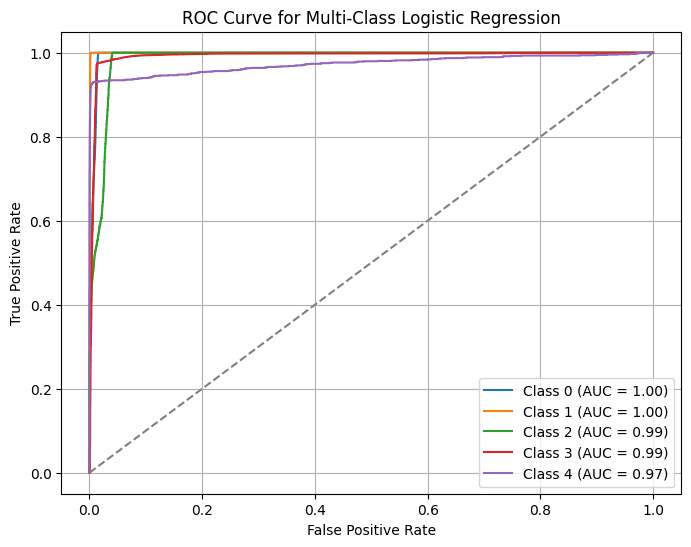

In [202]:
import sklearn.metrics


plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixLR.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 2- Decision Tree

In [203]:
import sklearn.tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
}
# ModelDT = sklearn.tree.DecisionTreeClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelDT, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelDT = sklearn.tree.DecisionTreeClassifier(**best_params, class_weight='balanced')
# ModelDT.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelDT = sklearn.tree.DecisionTreeClassifier(class_weight='balanced')

In [204]:
ModelDT.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

DecisionTreeClassifier(class_weight='balanced')

In [205]:
ypred = ModelDT.predict(DFTestInputScaledSelected)
ypredProba = ModelDT.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixDT = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixDT

array([[ 1989,     0,    21,     0,     0],
       [    0,   585,     0,    46,     0],
       [   22,     0,  2711,    48,     1],
       [    1,    34,    48, 66232,    93],
       [    1,     0,     4,    93,  1229]])

In [206]:
accuracyDT, balanced_accuracyDT, precisionDT, recallDT, f1DT, roc_aucDT, matthews_corrcoefDT = ComputeMetrics(TestOutput, ypred, ypredProba)

In [207]:
print(f'{'accuracy': <30}', accuracyDT)
print(f'{'balanced_accuracy': <30}', balanced_accuracyDT)
print(f'{'precision': <30}', precisionDT)
print(f'{'recall': <30}', recallDT)
print(f'{'f1': <30}', f1DT)
print(f'{'roc_auc': <30}', roc_aucDT)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefDT)

accuracy                       0.9943683534268296
balanced_accuracy              0.9629259596412533
precision                      0.9943570880819397
recall                         0.9943683534268296
f1                             0.9943619122318068
roc_auc                        0.9846001058669636
matthews_corrcoef              0.9674999004502322


In [208]:
LogLossDT = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossDT)

Log Loss:  0.20114216348981048


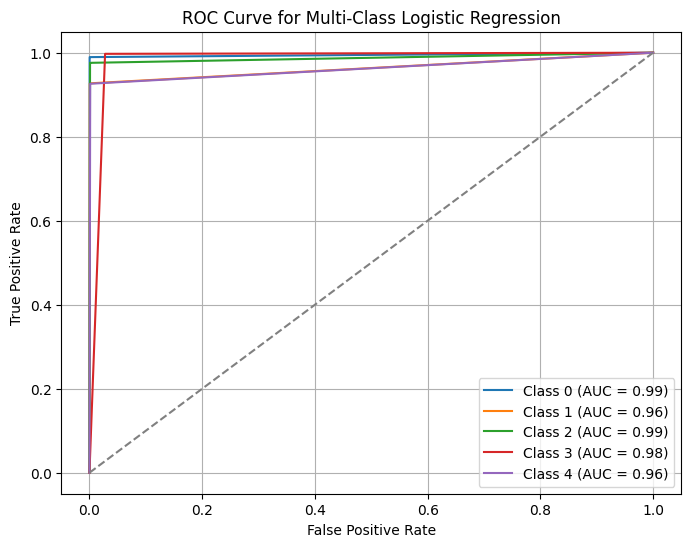

In [209]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixDT.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 3- Random Forest

In [210]:
# make a random search for the best hyperparameters of the random forest model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
}
# ModelRF = sklearn.ensemble.RandomForestClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelRF, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelRF = sklearn.ensemble.RandomForestClassifier(**best_params, class_weight='balanced')
# ModelRF.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelRF = sklearn.ensemble.RandomForestClassifier(class_weight='balanced')

In [211]:
ModelRF.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ypred = ModelRF.predict(DFTestInputScaledSelected)
ypredProba = ModelRF.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixRF = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixRF

array([[ 1995,     0,    15,     0,     0],
       [    0,   625,     0,     6,     0],
       [   25,     0,  2737,    20,     0],
       [    2,    42,    17, 66338,     9],
       [    1,     0,     0,   102,  1224]])

In [212]:
accuracyRF, balanced_accuracyRF, precisionRF, recallRF, f1RF, roc_aucRF, matthews_corrcoefRF = ComputeMetrics(TestOutput, ypred, ypredProba)

In [213]:
print(f'{'accuracy': <30}', accuracyRF)
print(f'{'balanced_accuracy': <30}', balanced_accuracyRF)
print(f'{'precision': <30}', precisionRF)
print(f'{'recall': <30}', recallRF)
print(f'{'f1': <30}', f1RF)
print(f'{'roc_auc': <30}', roc_aucRF)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefRF)

accuracy                       0.996733098225758
balanced_accuracy              0.9776360810195017
precision                      0.9967566380633628
recall                         0.996733098225758
f1                             0.9967143954540976
roc_auc                        0.9955376710154802
matthews_corrcoef              0.9811005250173509


In [214]:
LogLossRF = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossRF)

Log Loss:  0.03728890635189341


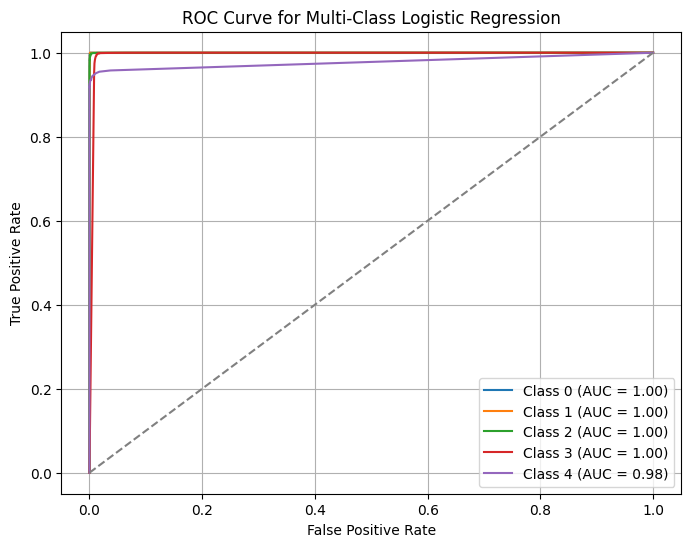

In [215]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixRF.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 4- SVM

In [216]:
import sklearn.svm
# make a random search for the best hyperparameters of the SVM model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(1, 5),
    'gamma': ['scale', 'auto'],
    'coef0': uniform(0, 1),
    'shrinking': [True, False],
}
# ModelSVM = sklearn.svm.SVC(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelSVM, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelSVM = sklearn.svm.SVC(**best_params, class_weight='balanced')
# ModelSVM.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

ModelSVM = sklearn.svm.LinearSVC()

In [217]:
ModelSVM.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

LinearSVC()

In [218]:
ypred = ModelSVM.predict(DFTestInputScaledSelected)
ypredProba = ModelSVM._predict_proba_lr(DFTestInputScaledSelected)
ConfusionMatrixSVM = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixSVM

array([[ 2007,     0,     2,     1,     0],
       [    0,   585,     9,    37,     0],
       [ 1080,     0,  1120,   582,     0],
       [    2,    64,   392, 65945,     5],
       [    5,     0,     1,   178,  1143]])

In [219]:
accuracySVM, balanced_accuracySVM, precisionSVM, recallSVM, f1SVM, roc_aucSVM, matthews_corrcoefSVM = ComputeMetrics(TestOutput, ypred, ypredProba)

In [220]:
print(f'{'accuracy': <30}', accuracySVM)
print(f'{'balanced_accuracy': <30}', balanced_accuracySVM)
print(f'{'precision': <30}', precisionSVM)
print(f'{'recall': <30}', recallSVM)
print(f'{'f1': <30}', f1SVM)
print(f'{'roc_auc': <30}', roc_aucSVM)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefSVM)

accuracy                       0.9677683917001558
balanced_accuracy              0.8365129380604144
precision                      0.9684839891605835
recall                         0.9677683917001558
f1                             0.965164194912079
roc_auc                        0.9903742683649519
matthews_corrcoef              0.8114356882581528


In [221]:
LogLossSVM = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossSVM)

Log Loss:  0.38605755132562164


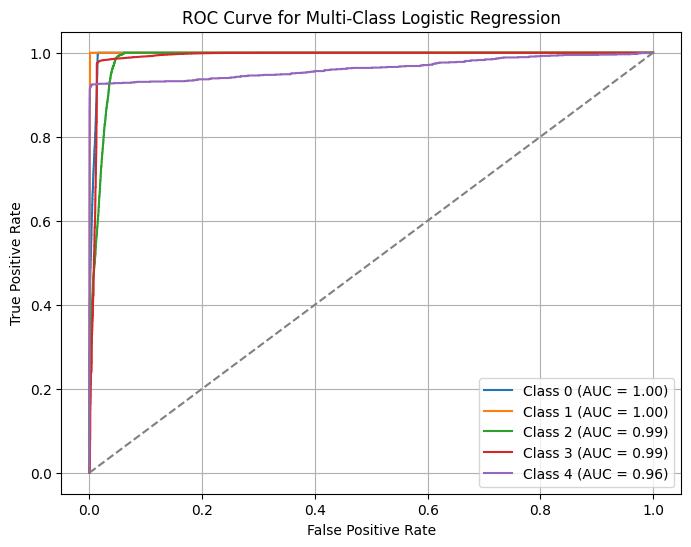

In [222]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixSVM.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 5- KNN

In [223]:
# knn
import sklearn.neighbors
# make a random search for the best hyperparameters of the knn model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': randint(1, 50),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}
# ModelKNN = sklearn.neighbors.KNeighborsClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelKNN, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelKNN = sklearn.neighbors.KNeighborsClassifier(**best_params, class_weight='balanced')
# ModelKNN.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ModelKNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=7)


In [224]:
ModelKNN.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())

KNeighborsClassifier(n_neighbors=7)

In [225]:
ypred = ModelKNN.predict(DFTestInputScaledSelected)
ypredProba = ModelKNN.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixKNN = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixKNN


array([[ 1954,     0,    53,     0,     3],
       [    0,   587,     2,    42,     0],
       [   91,     0,  2645,    46,     0],
       [    2,    55,    59, 66284,     8],
       [    4,     0,     9,   112,  1202]])

In [226]:
accuracyKNN, balanced_accuracyKNN, precisionKNN, recallKNN, f1KNN, roc_aucKNN, matthews_corrcoefKNN = ComputeMetrics(TestOutput, ypred, ypredProba)

In [227]:
print(f'{'accuracy': <30}', accuracyKNN)
print(f'{'balanced_accuracy': <30}', balanced_accuracyKNN)
print(f'{'precision': <30}', precisionKNN)
print(f'{'recall': <30}', recallKNN)
print(f'{'f1': <30}', f1KNN)
print(f'{'roc_auc': <30}', roc_aucKNN)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefKNN)

accuracy                       0.9933568440908718
balanced_accuracy              0.9514197773991631
precision                      0.9933767207665107
recall                         0.9933568440908718
f1                             0.9933283144251266
roc_auc                        0.9928490978883223
matthews_corrcoef              0.961511523855091


In [228]:
LogLossKNN = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossKNN)

Log Loss:  0.08019529041811178


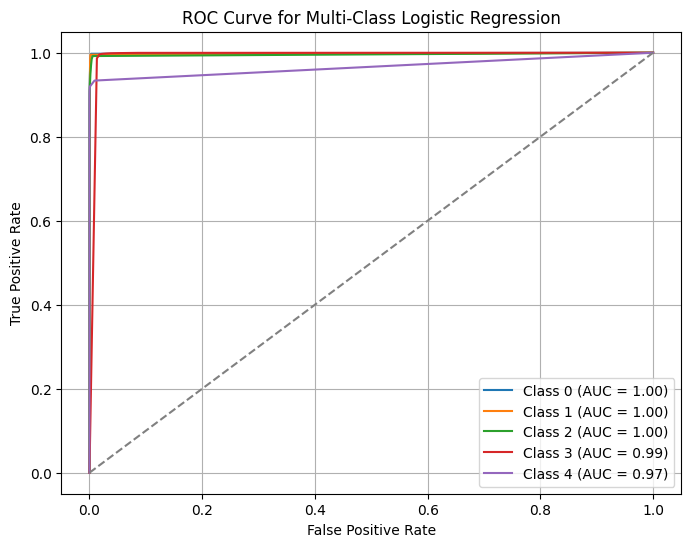

In [229]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixKNN.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 6- XGBClassifier

In [230]:
# XGBClassifier

import xgboost as xgb
# make a random search for the best hyperparameters of the xgboost model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
}
# ModelXGB = xgb.XGBClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelXGB, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelXGB = xgb.XGBClassifier(**best_params, class_weight='balanced')
# ModelXGB.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ModelXGB = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', class_weight='balanced')


In [231]:
ModelXGB.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())


XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [232]:
ypred = ModelXGB.predict(DFTestInputScaledSelected)
ypredProba = ModelXGB.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixXGB = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixXGB


array([[ 2000,     0,    10,     0,     0],
       [    0,   610,     0,    21,     0],
       [   25,     0,  2736,    21,     0],
       [    2,    36,    19, 66343,     8],
       [    1,     0,     1,   104,  1221]])

In [233]:
accuracyXGB, balanced_accuracyXGB, precisionXGB, recallXGB, f1XGB, roc_aucXGB, matthews_corrcoefXGB = ComputeMetrics(TestOutput, ypred, ypredProba)

In [234]:
print(f'{'accuracy': <30}', accuracyXGB)
print(f'{'balanced_accuracy': <30}', balanced_accuracyXGB)
print(f'{'precision': <30}', precisionXGB)
print(f'{'recall': <30}', recallXGB)
print(f'{'f1': <30}', f1XGB)
print(f'{'roc_auc': <30}', roc_aucXGB)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefXGB)

accuracy                       0.9966100768200333
balanced_accuracy              0.9728702552946812
precision                      0.996616239443846
recall                         0.9966100768200333
f1                             0.9965853185025607
roc_auc                        0.9981819377791441
matthews_corrcoef              0.9803656540787812


In [235]:
LogLossXGB = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossXGB)

Log Loss:  0.013041641801999963


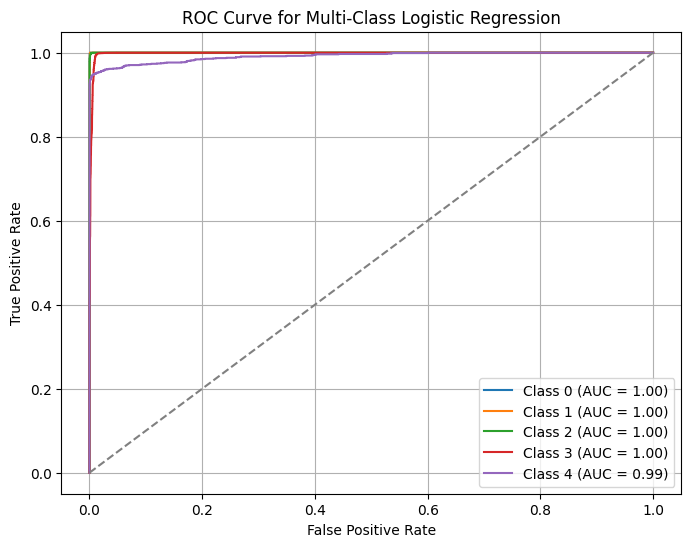

In [236]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixXGB.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 7- LGBMClassifier

In [237]:
# LGBMClassifier
import lightgbm as lgb
# make a random search for the best hyperparameters of the lightgbm model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}
# ModelLGBM = lgb.LGBMClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelLGBM, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelLGBM = lgb.LGBMClassifier(**best_params, class_weight='balanced')
# ModelLGBM.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ModelLGBM = lgb.LGBMClassifier()


In [238]:
ModelLGBM.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 292630, number of used features: 12
[LightGBM] [Info] Start training from score -3.594604
[LightGBM] [Info] Start training from score -4.752272
[LightGBM] [Info] Start training from score -3.269534
[LightGBM] [Info] Start training from score -0.096797
[LightGBM] [Info] Start training from score -4.010071


LGBMClassifier()

In [239]:
ypred = ModelLGBM.predict(DFTestInputScaledSelected)
ypredProba = ModelLGBM.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixLGBM = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixLGBM

array([[ 1952,     0,    33,    25,     0],
       [    1,   604,     2,    24,     0],
       [   29,     1,  2696,    54,     2],
       [    4,    39,    24, 66310,    31],
       [    0,     0,     6,   101,  1220]])

In [240]:
accuracyLGBM, balanced_accuracyLGBM, precisionLGBM, recallLGBM, f1LGBM, roc_aucLGBM, matthews_corrcoefLGBM = ComputeMetrics(TestOutput, ypred, ypredProba)

In [241]:
print(f'{'accuracy': <30}', accuracyLGBM)
print(f'{'balanced_accuracy': <30}', balanced_accuracyLGBM)
print(f'{'precision': <30}', precisionLGBM)
print(f'{'recall': <30}', recallLGBM)
print(f'{'f1': <30}', f1LGBM)
print(f'{'roc_auc': <30}', roc_aucLGBM)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefLGBM)


accuracy                       0.994860439049728
balanced_accuracy              0.9630666620664652
precision                      0.9948369060539478
recall                         0.994860439049728
f1                             0.9948316236154034
roc_auc                        0.9885281928706366
matthews_corrcoef              0.9701787364135386


In [242]:
LogLossLGBM = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossLGBM)

Log Loss:  0.06546577038946427


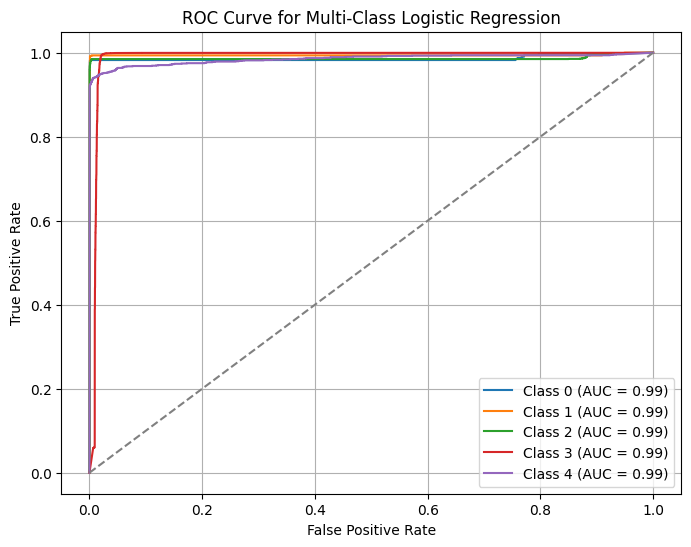

In [243]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixLGBM.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 8- ExtraTreesClassifier

In [244]:
# ExtraTreesClassifier
import sklearn.ensemble
# make a random search for the best hyperparameters of the ExtraTreesClassifier model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
}
# ModelETC = sklearn.ensemble.ExtraTreesClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelETC, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelETC = sklearn.ensemble.ExtraTreesClassifier(**best_params, class_weight='balanced')
# ModelETC.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ModelETC = sklearn.ensemble.ExtraTreesClassifier(class_weight='balanced')

In [245]:
ModelETC.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())


ExtraTreesClassifier(class_weight='balanced')

In [246]:
ypred = ModelETC.predict(DFTestInputScaledSelected)
ypredProba = ModelETC.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixETC = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixETC


array([[ 1998,     0,    12,     0,     0],
       [    0,   627,     0,     4,     0],
       [   19,     0,  2744,    19,     0],
       [    2,    52,    16, 66304,    34],
       [    2,     0,     0,    99,  1226]])

In [247]:
accuracyETC, balanced_accuracyETC, precisionETC, recallETC, f1ETC, roc_aucETC, matthews_corrcoefETC = ComputeMetrics(TestOutput, ypred, ypredProba)

In [248]:
print(f'{'accuracy': <30}', accuracyETC)
print(f'{'balanced_accuracy': <30}', balanced_accuracyETC)
print(f'{'precision': <30}', precisionETC)
print(f'{'recall': <30}', recallETC)
print(f'{'f1': <30}', f1ETC)
print(f'{'roc_auc': <30}', roc_aucETC)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefETC)



accuracy                       0.9964597173241477
balanced_accuracy              0.9792707724859409
precision                      0.9964860342327017
recall                         0.9964597173241477
f1                             0.9964498953075489
roc_auc                        0.9952845065156707
matthews_corrcoef              0.9795645826065869


In [249]:
LogLossETC = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossETC)


Log Loss:  0.041540402958571664


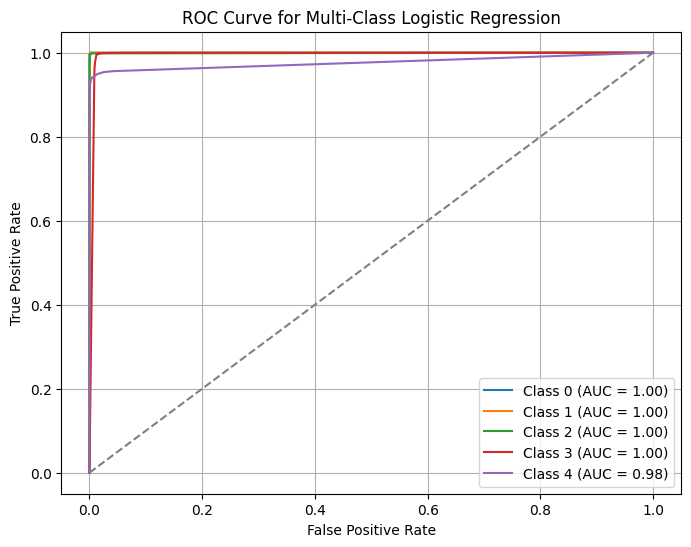

In [250]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixETC.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 9- BaggingClassifier

In [251]:
# BaggingClassifier
import sklearn.ensemble
# make a random search for the best hyperparameters of the BaggingClassifier model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
param_distributions = {
    'n_estimators': randint(10, 200),
    'max_samples': uniform(0.1, 1.0),
    'max_features': uniform(0.1, 1.0),
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
}
# ModelBC = sklearn.ensemble.BaggingClassifier(class_weight='balanced')
# random_search = RandomizedSearchCV(ModelBC, param_distributions, n_iter=10, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
# random_search.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
# best_params = random_search.best_params_
# print("Best Hyperparameters: ", best_params)
# ModelBC = sklearn.ensemble.BaggingClassifier(**best_params, class_weight='balanced')
# ModelBC.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())
ModelBC = sklearn.ensemble.BaggingClassifier()


In [252]:
ModelBC.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())


BaggingClassifier()

In [253]:
ypred = ModelBC.predict(DFTestInputScaledSelected)
ypredProba = ModelBC.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixBC = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixBC


array([[ 1994,     0,    16,     0,     0],
       [    1,   622,     0,     8,     0],
       [   22,     0,  2742,    18,     0],
       [    2,    47,    33, 66306,    20],
       [    1,     0,     2,   100,  1224]])

In [254]:
accuracyBC, balanced_accuracyBC, precisionBC, recallBC, f1BC, roc_aucBC, matthews_corrcoefBC = ComputeMetrics(TestOutput, ypred, ypredProba)

In [255]:
print(f'{'accuracy': <30}', accuracyBC)
print(f'{'balanced_accuracy': <30}', balanced_accuracyBC)
print(f'{'precision': <30}', precisionBC)
print(f'{'recall': <30}', recallBC)
print(f'{'f1': <30}', f1BC)
print(f'{'roc_auc': <30}', roc_aucBC)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefBC)


accuracy                       0.9963093578282621
balanced_accuracy              0.9768487865992398
precision                      0.9963327365900132
recall                         0.9963093578282621
f1                             0.9962956276616997
roc_auc                        0.994100999709073
matthews_corrcoef              0.9786882495289104


In [256]:
LogLossBC = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossBC)


Log Loss:  0.05427354573080815


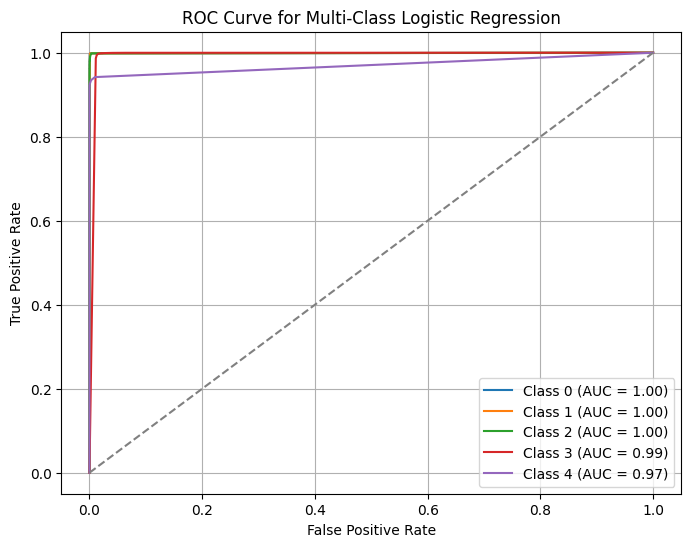

In [257]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixBC.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## 10- VotingClassifier

In [144]:
# VotingClassifier
import sklearn.ensemble
# make a random search for the best hyperparameters of the VotingClassifier model
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
import sklearn.linear_model
import sklearn.ensemble
import sklearn.tree
import sklearn.svm
import sklearn.neighbors
from scipy.stats import uniform, randint

ModelVC = sklearn.ensemble.VotingClassifier(estimators=[('lr', sklearn.linear_model.LogisticRegression()),
                   ('rf', sklearn.ensemble.RandomForestClassifier()),
                   ('dt', sklearn.tree.DecisionTreeClassifier()),
                   ('svc', sklearn.svm.SVC(probability=True)),
                   ('knn', sklearn.neighbors.KNeighborsClassifier()),
                   ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
                   ('lgbm', lgb.LGBMClassifier()),
                   ('etc', sklearn.ensemble.ExtraTreesClassifier()),
                   ('bc', sklearn.ensemble.BaggingClassifier())], voting='soft')


In [ ]:
ModelVC.fit(DFTrainInputScaledSelected, TrainOutput.values.ravel())


In [ ]:
ypred = ModelVC.predict(DFTestInputScaledSelected)
ypredProba = ModelVC.predict_proba(DFTestInputScaledSelected)
ConfusionMatrixVC = sklearn.metrics.confusion_matrix(TestOutput, ypred)
ConfusionMatrixVC


In [ ]:
accuracyVC, balanced_accuracyVC, precisionVC, recallVC, f1VC, roc_aucVC, matthews_corrcoefVC = ComputeMetrics(TestOutput, ypred, ypredProba)

In [ ]:
print(f'{'accuracy': <30}', accuracyVC)
print(f'{'balanced_accuracy': <30}', balanced_accuracyVC)
print(f'{'precision': <30}', precisionVC)
print(f'{'recall': <30}', recallVC)
print(f'{'f1': <30}', f1VC)
print(f'{'roc_auc': <30}', roc_aucVC)
print(f'{'matthews_corrcoef': <30}', matthews_corrcoefVC)


In [ ]:
LogLossVC = sklearn.metrics.log_loss(TestOutput, ypredProba)
print("Log Loss: ", LogLossVC)


In [ ]:
import sklearn.metrics

plt.figure(figsize=(8, 6))
for i in range(ConfusionMatrixVC.shape[0]):
    fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
    auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
    plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Logistic Regression")
plt.legend()
plt.grid()
plt.show()

## Visualizations and Comparisons

In [262]:
ModelNames = [
    "Logistic Regression", "Decision Tree", "Random Forest", "SVM", "KNN",
    "XGBoost", "LightGBM", "Extra Trees", "Bagging"
]
MetricNames = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Log Loss', 'Matthews Correlation Coefficient']


In [263]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from builtins import min, max

def PlotArrayVSModelNames(array, PlotName : str):
    sorted_indices = numpy.argsort(array)
    sorted_array = numpy.array(array)[sorted_indices]
    sorted_names = numpy.array(ModelNames)[sorted_indices]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=sorted_array, y=sorted_names, palette="Blues_d", orient='h')

    for i, (loss, name) in enumerate(zip(sorted_array, sorted_names)):
        plt.text(loss + 0.001, i, f"{loss:.4f}", va='center', fontsize=9)

    min_loss = min(sorted_array)
    max_loss = max(sorted_array)
    plt.xlim(min_loss - 0.01, max_loss + 0.01)

    plt.xlabel(PlotName)
    plt.title(f"Model {PlotName} Comparison")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()


In [264]:

ModelsMetrics = {
    'Logistic Regression': {
        'Accuracy': accuracyLR,
        'Balanced Accuracy': balanced_accuracyLR,
        'Precision': precisionLR,
        'Recall': recallLR,
        'F1-Score': f1LR,
        'ROC AUC': roc_aucLR,
        'Log Loss': LogLossLR,
        'Matthews Correlation Coefficient': matthews_corrcoefLR,
    },
    'Decision Tree': {
        'Accuracy': accuracyDT,
        'Balanced Accuracy': balanced_accuracyDT,
        'Precision': precisionDT,
        'Recall': recallDT,
        'F1-Score': f1DT,
        'ROC AUC': roc_aucDT,
        'Log Loss': LogLossDT,
        'Matthews Correlation Coefficient': matthews_corrcoefDT,
    },
    'Random Forest': {
        'Accuracy': accuracyRF,
        'Balanced Accuracy': balanced_accuracyRF,
        'Precision': precisionRF,
        'Recall': recallRF,
        'F1-Score': f1RF,
        'ROC AUC': roc_aucRF,
        'Log Loss': LogLossRF,
        'Matthews Correlation Coefficient': matthews_corrcoefRF,
    },
    'SVM': {
        'Accuracy': accuracySVM,
        'Balanced Accuracy': balanced_accuracySVM,
        'Precision': precisionSVM,
        'Recall': recallSVM,
        'F1-Score': f1SVM,
        'ROC AUC': roc_aucSVM,
        'Log Loss': LogLossSVM,
        'Matthews Correlation Coefficient': matthews_corrcoefSVM,
    },
    'KNN': {
        'Accuracy': accuracyKNN,
        'Balanced Accuracy': balanced_accuracyKNN,
        'Precision': precisionKNN,
        'Recall': recallKNN,
        'F1-Score': f1KNN,
        'ROC AUC': roc_aucKNN,
        'Log Loss': LogLossKNN,
        'Matthews Correlation Coefficient': matthews_corrcoefKNN,
    },
    'XGBoost': {
        'Accuracy': accuracyXGB,
        'Balanced Accuracy': balanced_accuracyXGB,
        'Precision': precisionXGB,
        'Recall': recallXGB,
        'F1-Score': f1XGB,
        'ROC AUC': roc_aucXGB,
        'Log Loss': LogLossXGB,
        'Matthews Correlation Coefficient': matthews_corrcoefXGB,
    },
    'LightGBM': {
        'Accuracy': accuracyLGBM,
        'Balanced Accuracy': balanced_accuracyLGBM,
        'Precision': precisionLGBM,
        'Recall': recallLGBM,
        'F1-Score': f1LGBM,
        'ROC AUC': roc_aucLGBM,
        'Log Loss': LogLossLGBM,
        'Matthews Correlation Coefficient': matthews_corrcoefLGBM,
    },
    'Extra Trees': {
        'Accuracy': accuracyETC,
        'Balanced Accuracy': balanced_accuracyETC,
        'Precision': precisionETC,
        'Recall': recallETC,
        'F1-Score': f1ETC,
        'ROC AUC': roc_aucETC,
        'Log Loss': LogLossETC,
        'Matthews Correlation Coefficient': matthews_corrcoefETC,
    },
    'Bagging': {
        'Accuracy': accuracyBC,
        'Balanced Accuracy': balanced_accuracyBC,
        'Precision': precisionBC,
        'Recall': recallBC,
        'F1-Score': f1BC,
        'ROC AUC': roc_aucBC,
        'Log Loss': LogLossBC,
        'Matthews Correlation Coefficient': matthews_corrcoefBC,
    },
}

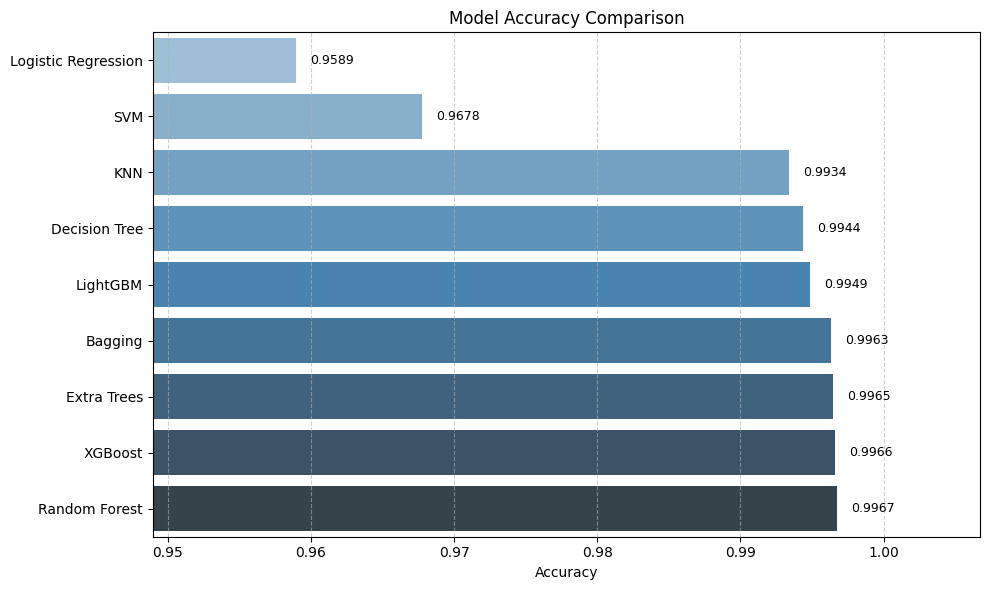

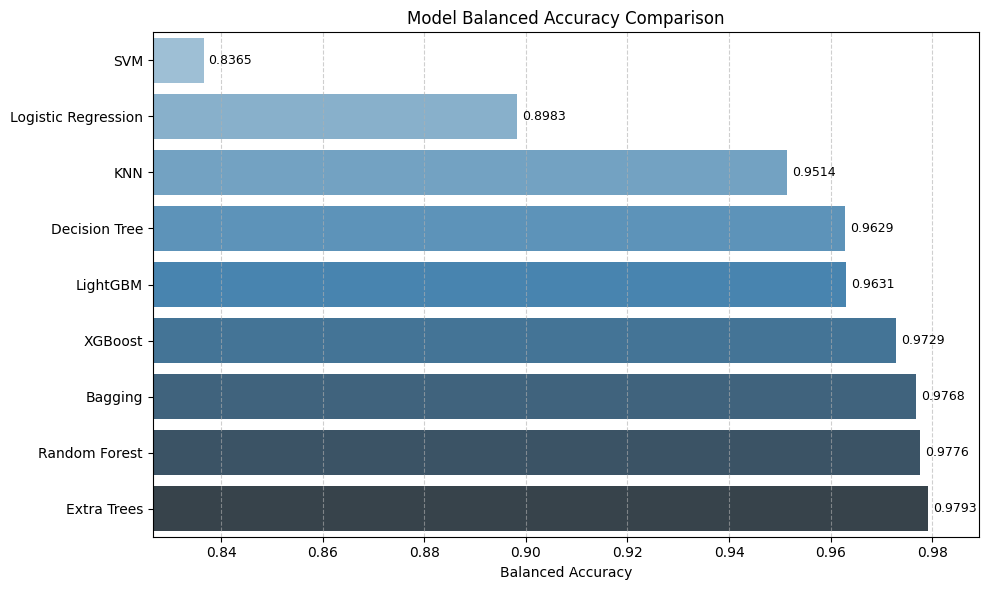

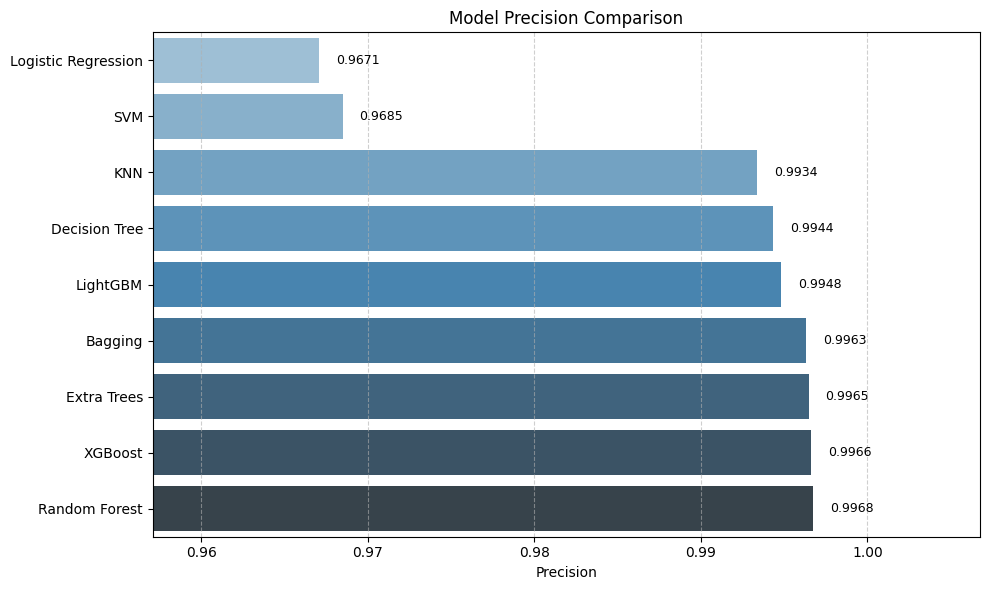

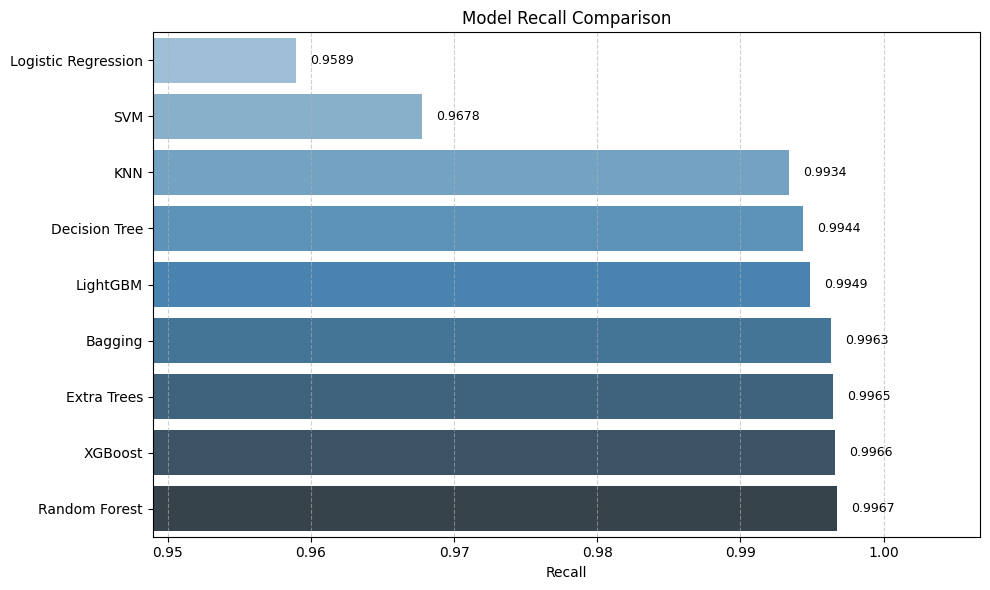

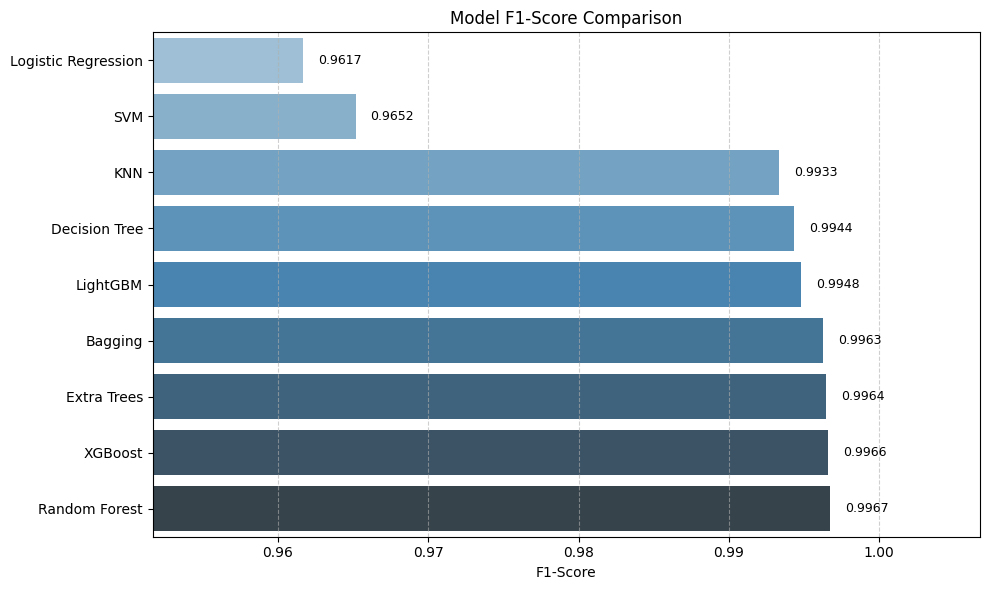

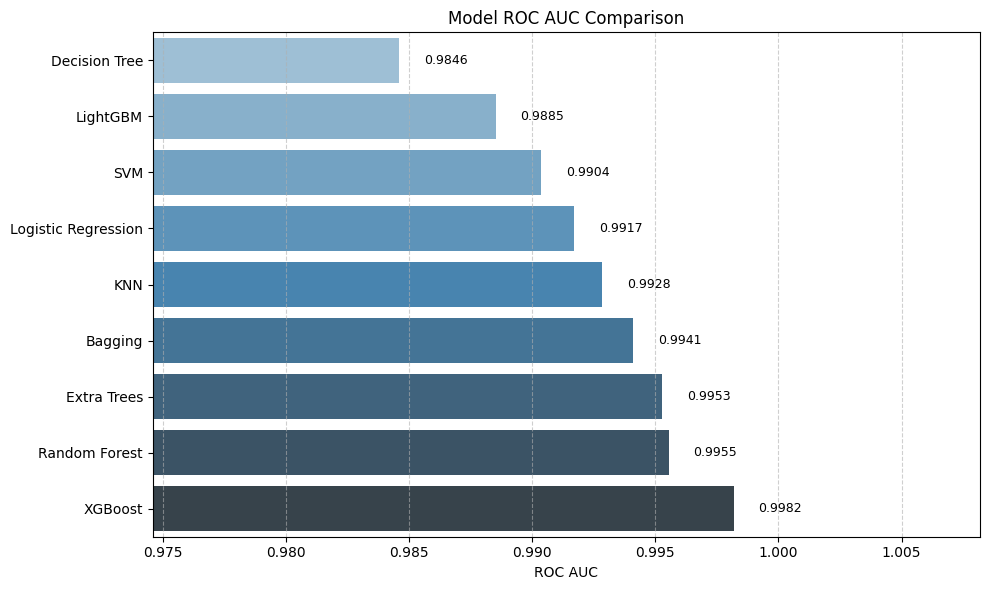

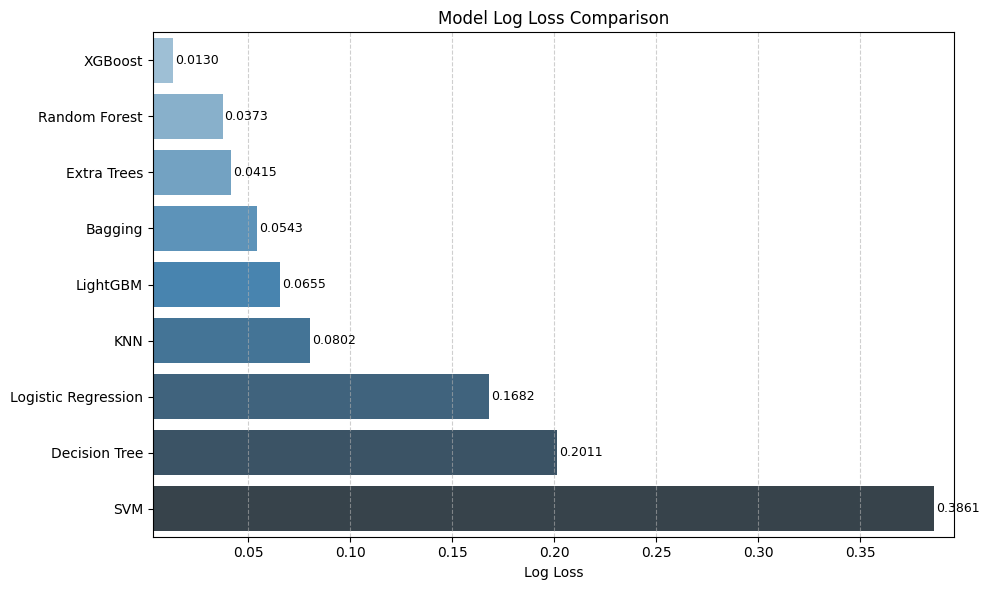

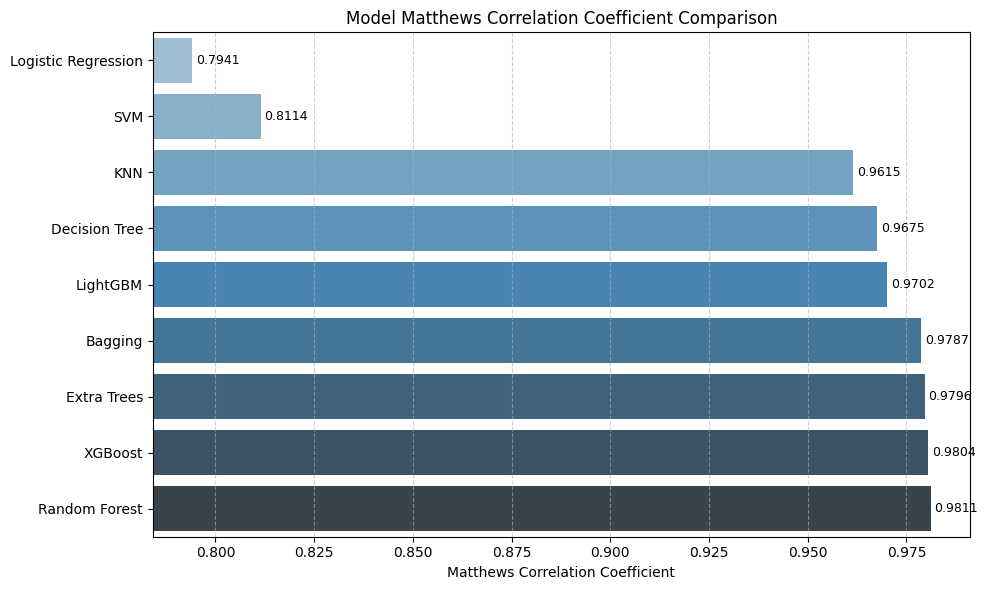

In [265]:
def GetMetric(metric : str) -> list:
    return [metrics[metric] for _ , metrics in ModelsMetrics.items()]

for metric in MetricNames:
    PlotArrayVSModelNames(GetMetric(metric), metric)

In [266]:
MinMaxMetricsIndex : dict[str, tuple] = {
}
for metric in MetricNames:
    min, max = numpy.argmin(GetMetric(metric)), numpy.argmax(GetMetric(metric))
    MinMaxMetricsIndex[metric] = (min, max)



In [267]:
# Print the model names corresponding to the indices
print(f'{"Minimum loss: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['Log Loss'][0]]}, with a value of : ': <35}", GetMetric('Log Loss')[MinMaxMetricsIndex['Log Loss'][0]])
print(f'{"Maximum accuracy: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['Accuracy'][1]]}, with a value of : ': <35}", GetMetric('Accuracy')[MinMaxMetricsIndex['Accuracy'][1]])
print(f'{"Maximum balanced accuracy: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['Balanced Accuracy'][1]]}, with a value of : ': <35}", GetMetric('Balanced Accuracy')[MinMaxMetricsIndex['Balanced Accuracy'][1]])
print(f'{"Maximum precision: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['Precision'][1]]}, with a value of : ': <35}", GetMetric('Precision')[MinMaxMetricsIndex['Precision'][1]])
print(f'{"Maximum recall: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['Recall'][1]]}, with a value of : ': <35}", GetMetric('Recall')[MinMaxMetricsIndex['Recall'][1]])
print(f'{"Maximum F1 score: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['F1-Score'][1]]}, with a value of : ': <35}", GetMetric('F1-Score')[MinMaxMetricsIndex['F1-Score'][1]])
print(f'{"Maximum ROC AUC: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['ROC AUC'][1]]}, with a value of : ': <35}", GetMetric('ROC AUC')[MinMaxMetricsIndex['ROC AUC'][1]])
print(f'{"Maximum Matthews correlation coefficient: ": <45}', f"{f'{ModelNames[MinMaxMetricsIndex['Matthews Correlation Coefficient'][1]]}, with a value of : ': <35}", GetMetric('Matthews Correlation Coefficient')[MinMaxMetricsIndex['Matthews Correlation Coefficient'][1]])


Minimum loss:                                 XGBoost, with a value of :          0.013041641801999963
Maximum accuracy:                             Random Forest, with a value of :    0.996733098225758
Maximum balanced accuracy:                    Extra Trees, with a value of :      0.9792707724859409
Maximum precision:                            Random Forest, with a value of :    0.9967566380633628
Maximum recall:                               Random Forest, with a value of :    0.996733098225758
Maximum F1 score:                             Random Forest, with a value of :    0.9967143954540976
Maximum ROC AUC:                              XGBoost, with a value of :          0.9981819377791441
Maximum Matthews correlation coefficient:     Random Forest, with a value of :    0.9811005250173509


In [290]:
import os
import pickle

def SaveInfo(Models, Metrics, OutputFolder):
    ModelsOutputFolder = f'{OutputFolder}/Models'
    MetricsOutputFolder = f'{OutputFolder}/Metrics'
    os.makedirs(ModelsOutputFolder, exist_ok=True)
    os.makedirs(MetricsOutputFolder, exist_ok=True)

    metrics_file_path = os.path.join(MetricsOutputFolder, "ModelsMetrics.pkl")
    with open(metrics_file_path, "wb") as metrics_file:
        pickle.dump(Metrics, metrics_file)


    for model_name, model in Models.items():
        model_file_path = os.path.join(ModelsOutputFolder, f"{model_name}.pkl")
        with open(model_file_path, "wb") as model_file:
            pickle.dump(model, model_file)

    print(f"Models and metrics saved in the folder: {OutputFolder}")

def LoadInfo(InputFolder):
    ModelsInputFolder = f'{InputFolder}/Models'
    MetricsInputFolder = f'{InputFolder}/Metrics'

    # Load metrics
    metrics_file_path = os.path.join(MetricsInputFolder, "ModelsMetrics.pkl")
    with open(metrics_file_path, "rb") as metrics_file:
        Metrics = pickle.load(metrics_file)

    # Load models
    Models = {}
    for model_file in os.listdir(ModelsInputFolder):
        model_name = os.path.splitext(model_file)[0]
        model_file_path = os.path.join(ModelsInputFolder, model_file)
        with open(model_file_path, "rb") as model_file:
            Models[model_name] = pickle.load(model_file)

    return Models, Metrics


In [295]:
CurrentModels = {
    "LogisticRegression": ModelLR,
    "DecisionTree": ModelDT,
    "RandomForest": ModelRF,
    "SVM": ModelSVM,
    "KNN": ModelKNN,
    "XGBoost": ModelXGB,
    "LightGBM": ModelLGBM,
    "ExtraTrees": ModelETC,
    "Bagging": ModelBC,
}
SaveInfo(CurrentModels, ModelsMetrics, 'MMFolder/MM1')

Models and metrics saved in the folder: MMFolder/MM1


In [268]:
"""
TODO: 
    - run the random search for all the models and use the best hyperparameters for each model
    - run the models with the best hyperparameters and compare the results
"""

# import sklearn.metrics

# accuracyLGBM = sklearn.metrics.accuracy_score(TestOutput,ypred)
# balanced_accuracyLGBM = sklearn.metrics.balanced_accuracy_score(TestOutput, ypred)
# precisionLGBM = sklearn.metrics.precision_score(TestOutput, ypred, average='weighted')
# recallLGBM = sklearn.metrics.recall_score(TestOutput, ypred, average='weighted')
# f1LGBM = sklearn.metrics.f1_score(TestOutput, ypred, average='weighted')
# roc_aucLGBM = sklearn.metrics.roc_auc_score(TestOutput, ypredProba, average='weighted', multi_class='ovr')
# matthews_corrcoefLGBM = sklearn.metrics.matthews_corrcoef(TestOutput,ypred)

# print(f'{'accuracy': <30}', accuracyLGBM)
# print(f'{'balanced_accuracy': <30}', balanced_accuracyLGBM)
# print(f'{'precision': <30}', precisionLGBM)
# print(f'{'recall': <30}', recallLGBM)
# print(f'{'f1': <30}', f1LGBM)
# print(f'{'roc_auc': <30}', roc_aucLGBM)
# print(f'{'matthews_corrcoef': <30}', matthews_corrcoefLGBM)

# LogLossLGBM = sklearn.metrics.log_loss(TestOutput, ypredProba)
# print("Log Loss: ", LogLossLGBM)
# import sklearn.metrics

# plt.figure(figsize=(8, 6))
# for i in range(ConfusionMatrixLGBM.shape[0]):
#     fpr_i, tpr_i, _ = sklearn.metrics.roc_curve(TestOutput == i, ypredProba[:, i])
#     auc = sklearn.metrics.roc_auc_score(TestOutput == i, ypredProba[:, i])
#     plt.plot(fpr_i, tpr_i, label=f"Class {i} (AUC = {auc:.2f})")

# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve for Multi-Class Logistic Regression")
# plt.legend()
# plt.grid()
# plt.show()

'\nTODO: \n    - run the random search for all the models and use the best hyperparameters for each model\n    - run the models with the best hyperparameters and compare the results\n'